In [25]:
import pandas as pd
import os

image_dir = "koniq10k_512x384"
image_files = [
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
print(f"Processing {len(image_files)} images")

Processing 10373 images


In [ ]:
from features import build_features, feature_names

df_features = build_features(image_dir, out_csv="features.csv")
print(df_features.shape)

In [ ]:
from scoring import compute_all_scores

compute_all_scores("koniq10k_512x384")

In [26]:
import numpy as np
from sklearn.linear_model import LinearRegression
import json

df_scores = pd.read_csv("iqa_raw_scores.csv")
df_mos = pd.read_csv("koniq10k_scores_and_distributions.csv")
df_features = pd.read_csv("features.csv")

if "image_name" not in df_scores.columns:
    df_scores.columns = ["image_name"] + list(df_scores.columns[1:])

df = df_scores.merge(df_mos[["image_name", "MOS"]], on="image_name")
df = df.merge(df_features, left_on="image_name", right_on="image_path")

iqa_methods = ["brisque", "niqe", "piqe", "maniqa", "hyperiqa"]
mos_predictions = {}
regression_coefficients = {}

for method in iqa_methods:
    reg = LinearRegression()
    X = df[[method]].values
    y = df["MOS"].values
    reg.fit(X, y)
    mos_predictions[f"{method}_mos"] = reg.predict(X)
    regression_coefficients[method] = {
        "coef": float(reg.coef_[0]),
        "intercept": float(reg.intercept_),
    }
    print(f"{method}: R²={reg.score(X, y):.4f}")

with open("mos_mapping_coefficients.json", "w") as f:
    json.dump(regression_coefficients, f, indent=2)

errors = {
    method: np.abs(mos_predictions[f"{method}_mos"] - df["MOS"].values)
    for method in iqa_methods
}
errors_df = pd.DataFrame(errors)
df["best_method"] = errors_df.idxmin(axis=1)
df["best_method_label"] = df["best_method"].map(
    {m: i for i, m in enumerate(iqa_methods)}
)
df["best_method_error"] = errors_df.min(axis=1)

print(f"\n{df['best_method'].value_counts()}")
df.to_csv("router_training_data.csv", index=False)
print(f"Dataset: {df.shape}")

brisque: R²=0.0487
niqe: R²=0.0832
piqe: R²=0.0177
maniqa: R²=0.8609
hyperiqa: R²=0.9099

best_method
hyperiqa    4978
maniqa      3256
niqe         650
piqe         626
brisque      563
Name: count, dtype: int64
Dataset: (10073, 22)


Training Accuracy: 0.8760


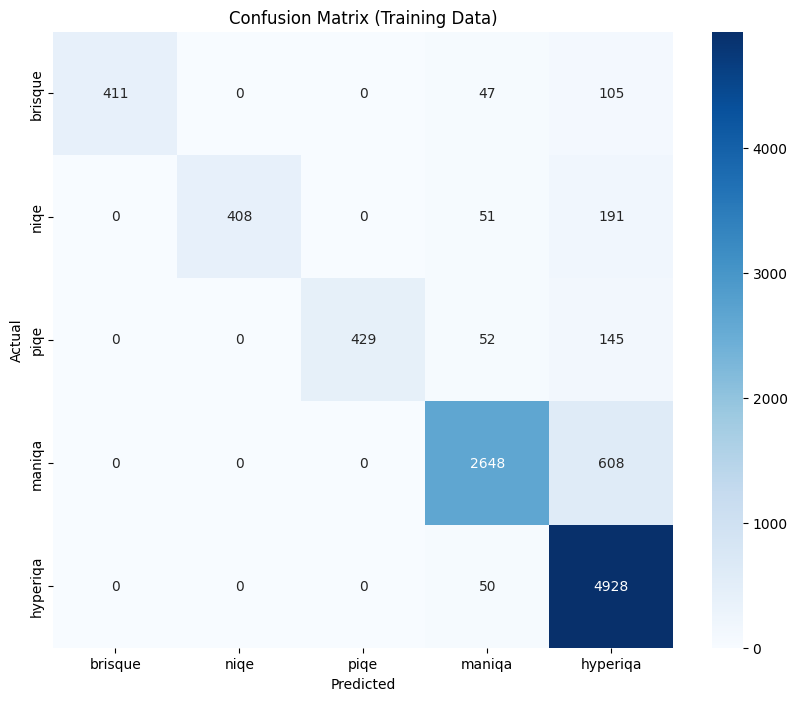


✓ Router trained on all data and saved!


In [27]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv("router_training_data.csv")
X = df[feature_names].values
y = df["best_method_label"].values

# Train on ALL data (no split - you'll test on separate dataset later)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

router = XGBClassifier(n_estimators=100, random_state=42)
router.fit(X_scaled, y, verbose=50)

# Training performance
y_pred = router.predict(X_scaled)
print(f"Training Accuracy: {np.mean(y_pred == y):.4f}")

# Confusion matrix on training data
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=iqa_methods,
    yticklabels=iqa_methods,
)
plt.title("Confusion Matrix (Training Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save router and scaler
router.save_model("router_xgb.json")
joblib.dump(scaler, "scaler.pkl")
print("\n✓ Router trained on all data and saved!")

In [28]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from router import predict

# Use same test split for evaluation (even though router trained on all data)
df_full = pd.read_csv("router_training_data.csv")
_, test_df = train_test_split(
    df_full, test_size=0.2, random_state=42, stratify=df_full["best_method_label"]
)

# Adaptive routing predictions
predictions, confidences, selected_methods, times = [], [], [], []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    try:
        result = predict(f"koniq10k_512x384/{row['image_name']}")
        predictions.append(result["MOS_estimate"])
        confidences.append(result["confidence"])
        selected_methods.append(result["selected_method"])
        times.append(result["timing"]["total_time_ms"])
    except Exception as e:
        print(f"Error: {e}")

ground_truth = test_df["MOS"].values[: len(predictions)]

# Compute metrics
srocc = spearmanr(predictions, ground_truth)[0]
plcc = pearsonr(predictions, ground_truth)[0]
rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
mae = mean_absolute_error(ground_truth, predictions)

print(f"\n{'='*60}")
print(f"ADAPTIVE ROUTING PERFORMANCE")
print(f"{'='*60}")
print(f"SROCC: {srocc:.4f}")
print(f"PLCC:  {plcc:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAE:   {mae:.4f}")
print(f"Avg Time: {np.mean(times):.2f}ms")
print(f"{'='*60}")

# Method usage statistics
from collections import Counter

method_counts = Counter(selected_methods)
print(f"\nMethod Selection Distribution:")
for method, count in method_counts.most_common():
    print(f"  {method}: {count} ({count/len(selected_methods)*100:.1f}%)")

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(
    ground_truth, predictions, alpha=0.5, s=30, edgecolors="black", linewidths=0.5
)
plt.plot([1, 5], [1, 5], "r--", linewidth=2, label="Perfect")
plt.xlabel("Ground Truth MOS")
plt.ylabel("Predicted MOS")
plt.title(f"Adaptive Routing\nSROCC={srocc:.4f}, PLCC={plcc:.4f}, RMSE={rmse:.4f}")
plt.legend()
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("prediction_scatter.png", dpi=300)
plt.show()

# Save detailed results
pd.DataFrame(
    {
        "image_name": test_df["image_name"].values[: len(predictions)],
        "ground_truth": ground_truth,
        "predicted": predictions,
        "method": selected_methods,
        "confidence": confidences,
        "time_ms": times,
        "error": np.abs(predictions - ground_truth),
    }
).to_csv("evaluation_results.csv", index=False)

print("\n✓ Evaluation complete! Results saved to 'evaluation_results.csv'")

  0%|          | 2/2015 [00:16<4:40:10,  8.35s/it]


KeyboardInterrupt: 

In [31]:
def assess_image(image_path):
    """
    Quick image quality assessment using deterministic routing.
    """
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    result = predict(image_path)

    print(f"Image: {os.path.basename(image_path)}")
    print(f"MOS: {result['MOS_estimate']:.3f}/5.0")
    print(
        f"Method: {result['selected_method']} (confidence: {result['confidence']:.3f})"
    )
    print(f"Time: {result['timing']['total_time_ms']:.2f}ms")
    return result


# Example usage
r = assess_image("me at night.jpg")

Image: me at night.jpg
MOS: 2.325/5.0
Method: maniqa (confidence: 0.557)
Time: 11548.90ms
